In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import theano 
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
def model_deriv(y, t, param):
    #Define parameters
    a,b,c=param
    #print(param)
    #define states
    V,R,dV_da,dV_db,dV_dc,dR_da,dR_db,dR_dc=y
    #define derivatives
    dV_dt=(V-((V**3)/3) +R)*c
    dR_dt=-(V-a+b*R)/c
    #define sensitivity odes
    dV_da_dt=c*(1-V**2)*dV_da + c*dR_da
    dV_db_dt=c*(1-V**2)*dV_db + c*dR_db
    dV_dc_dt=c*(1-V**2)*dV_dc + c*dR_dc + (V-((V**3)/3) +R)
    
    dR_da_dt=((-1/c)*dR_da) + ((-b/c)*dV_da) + 1/c
    dR_db_dt=((-1/c)*dR_db) + ((-b/c)*dV_db) + (-1*R/c)
    dR_dc_dt=((-1/c)*dR_dc) + ((-b/c)*dV_dc) + ((V-a+b*R)/c**2)
    return dV_dt,dR_dt, dV_da_dt,dV_db_dt,dV_dc_dt,  dR_da_dt,dR_db_dt,dR_dc_dt
    
def model_sol(param):
    
    y0 = [-1.,1.,0.,0.,0.,0.,0.,0.]
    time = np.linspace(0, 20, 100)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution,dtype=np.float64)

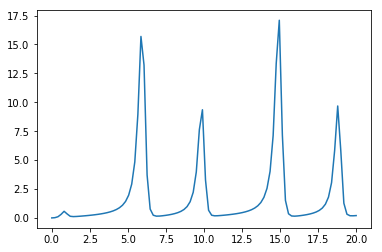

In [3]:
time = np.linspace(0, 20, 100)
sol = model_sol([0.2,0.2,3.])
plt.plot(time,sol[:,2])
#plt.plot(sol[:,5])

In [8]:
import numpy as np
import tensorflow as tf
import uuid

def relu(inputs):
    # Define the op in python
    def _relu(x):
        #print(x)
        sol = model_sol(np.array(x,dtype=np.float32))
        return sol[:,0]

    # Define the op's gradient in python
    def _relu_grad(x,v):
        #print(np.float32(x > 0))
        sol = model_sol(np.array(x,dtype=np.float32))
        #np.ones((3,201),dtype=np.float32).dot(v)
        return sol[:,2:5].T.dot(v)

    # An adapter that defines a gradient op compatible with TensorFlow
    def _relu_grad_op(op, grad):
        x = op.inputs[0]
        
        
        """
        rgrad = tf.reshape(grad,[400,1])
        reluG = tf.py_func(_relu_grad, [x], tf.float32)
        x_grad =tf.reduce_sum(tf.multiply(grad,reluG))
        x_grad = tf.matmul(rgrad,reluG,transpose_a=True)
        x_grad=tf.reshape(x_grad, [3,])
        """
        x_grad = tf.py_func(_relu_grad, [x,grad], tf.float32)
        
        
        return x_grad

    # Register the gradient with a unique id
    grad_name = "MyReluGrad_" + str(uuid.uuid4())
    tf.RegisterGradient(grad_name)(_relu_grad_op)

    # Override the gradient of the custom op
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": grad_name}):
        output = tf.py_func(_relu, [inputs], tf.float32)
    return output

3.8917412757873535
[385.18454   14.002306  20.278492]
[0.20096295 0.20008157 2.9946685 ]


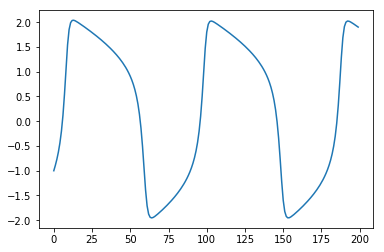

In [12]:
g = tf.random_uniform((1,),minval=0.199,maxval=0.201,)
z = tf.random_uniform((1,),minval=0.199,maxval=0.201,)
k = tf.random_uniform((1,),minval=2.99,maxval=3.01,)
x=tf.concat(0,[g,z,k])
#x=tf.nn.relu(g)

y = relu(x)

with tf.Session():
    diff = tf.test.compute_gradient_error(x, (3,), y, (200,))
    print(diff)
    #tf.global_variables_initializer().run()

    
    
    gr = tf.gradients(y, x)
    #
    print(gr[0].eval())
    plt.plot(y.eval())
    print(x.eval())

In [ ]:
import numpy as np
import tensorflow as tf
import uuid

def relu_new(a):
    # Define the op in python
    def _relu_new(x):
        return np.array(x*x )
    
    # Define the op's gradient in python
    def _relu_grad_new(x,v):
        return np.float32(2*x*v)

    # An adapter that defines a gradient op compatible with TensorFlow
    def _relu_grad_op_new(op, grad):
        x = op.inputs[0]
        
        x_grad =  tf.py_func(_relu_grad_new, [x,grad], tf.float32)
        
        #print(z.eval())
        #print(z.eval())
        #print(z_grad.eval())
        #print(x_grad.eval())
        return x_grad

    # Register the gradient with a unique id
    grad_name = "MyReluGrad_" + str(uuid.uuid4())
    tf.RegisterGradient(grad_name)(_relu_grad_op_new)

    # Override the gradient of the custom op
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": grad_name}):
        output = tf.py_func(_relu_new, [a], tf.float32)
    return output

In [ ]:
alpha = tf.random_normal([5,2,3])
beta = tf.random_normal([5,2,1])

test=tf.matmul(alpha,beta,transpose_a=True)
x=tf.nn.relu(alpha)

y=relu_new(x)
with tf.Session():
    diff = tf.test.compute_gradient_error(alpha, [5,2,3], y, [5,2,3])
    print(diff)    
    gr = tf.gradients(y, x)
    #
    print(gr[0].eval().shape)
    print(y.eval().shape)

   

In [3]:
class OpWrapper(theano.Op):

    def __init__(self, f, jac_f):
        self.f = f
        self.jac_f = jac_f

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        # `x` and `out` are arrays, so we can evaluate using `self.f`
        out[0] = np.asarray(self.f(x))

    def grad(self, inputs, output_grads):
        # `x` and `v` are symbolic here
        x = inputs[0]
        v = output_grads[0]

        op = self

        class OpGradWrapper(theano.Op):
            def __init__(self):
                pass

            def make_node(self, x, v):
                x = theano.tensor.as_tensor_variable(x)
                v = theano.tensor.as_tensor_variable(v)
                node = theano.Apply(self, [x, v], [v.type()])
                return node

            def perform(self, node, inputs_storage, output_storage):
                x = inputs_storage[0]
                v = inputs_storage[1]
                out = output_storage[0]
                out[0] = np.asarray(op.jac_f(x, v))

        grad_op = OpGradWrapper()
        grad_op_apply = grad_op(x, v)
        
        #grad = theano.dot(theano.tensor.transpose(grad_op_apply),v)
        return [grad_op_apply]

In [4]:
def f(x):
    sol = model_sol(np.array(x))
    return sol[:,0]
def jac_f(x, v):
    sol = model_sol(np.array(x))
    return sol[:,2:5].T.dot(v)

In [5]:
my_op = OpWrapper(f, jac_f)
x = theano.tensor.dvector()
y = my_op(x)
f = theano.function([x], [y])
np.shape(f([0.2,0.2,3.]))

(1, 100)

In [6]:
cost = y.sum()
gy = theano.grad(cost, x)
cost_grad = theano.function([x], [gy])


In [7]:
cost_grad([0.2,0.2,3.])

[array([191.73494749,   6.93012465,  10.10633675])]

In [8]:
class test_Double(utt.InferShapeTester):
    def setUp(self):
        super(test_Double, self).setUp()
        self.op_class = OpWrapper
        self.op = OpWrapper(f, jac_f)

    def test_basic(self):
        x = theano.tensor.vector()
        fth = theano.function([x], self.op(x))
        inp = numpy.asarray(numpy.random.rand(3), dtype=config.floatX)
        out = fth(inp)
        # Compare the result computed to the expected value.
        utt.assert_allclose(f(inp), out)
    def test_grad(self):
        theano.tests.unittest_tools.verify_grad(self.op,
                                            [numpy.random.rand(3)])

In [11]:
theano-nose test_file.py:test_Double

SyntaxError: invalid syntax (<ipython-input-11-a5eb692603fa>, line 1)